<a href="https://colab.research.google.com/github/adamDucken/adamDucken/blob/main/comparing_frac_diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fractional Differentiation of Time Series

In [5]:
#so we are going to try to learn how to fractionally differintiate time series data and not kill ourselves

##Importing Data
We import data from yahoo finance, in real life scenario you would not want to do that as the data from this source is very shitty, the quality is bad and there is really high chance that there are no alpha to be found, we use msft ticker and take daily data as much as possible, and we drop all columns except close  

In [6]:
import yfinance as yf

# Getting MSFT ticker
msft = yf.Ticker("MSFT")

# Get MSFT historical market data (daily)
df = msft.history(period="max")




In [7]:
# we take look at only 5 first records
df = df['Close']
df.head()
df.to_csv('/content/drive/MyDrive/datafolder/frac_diff_learn.csv')

##Helper Functions
Here is some helper functions, i got them all from book and some of them are modified but the essence is the same and we will need them to perform the fractional differencing

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def getWeights(d, size):
    """
    Calculate weights for fractional differencing
    :param d: fractional order of differencing
    :param size: size of the series
    :return: numpy array of weights
    """
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    return np.array(w[::-1]).reshape(-1, 1)

def plotWeights(dRange, nPlots, size):
    """
    Plot weights for different d values
    :param dRange: tuple of (min_d, max_d)
    :param nPlots: number of d values to plot
    :param size: size of the series
    """
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot()
    ax.legend(loc='upper left')
    plt.show()

def fracDiff(series, d, thres=.01):
    """
    Fractionally difference series using expanding window
    :param series: input time series
    :param d: fractional order of differencing
    :param thres: threshold for weight significance
    :return: fractionally differenced series
    """
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])

    # 2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]

    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]): continue  # exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):, :].T, seriesF.loc[:loc])[0, 0]
        df[name] = df_.copy(deep=True)
    return pd.concat(df, axis=1)

def getWeights_FFD(d, thres):
    """
    Calculate weights for fractional differencing (FFD method)
    :param d: fractional order of differencing
    :param thres: threshold for weight significance
    :return: numpy array of weights
    """
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def fracDiff_FFD(series, d, thres=1e-5):
    """
    Fractionally difference series using fixed-width window
    :param series: input time series
    :param d: fractional order of differencing
    :param thres: threshold for weight significance
    :return: fractionally differenced series
    """
    # 1) Compute weights for the longest series
    w = getWeights_FFD(d, thres)
    width = len(w) - 1

    # 2) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]): continue  # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    return pd.concat(df, axis=1)

def plotMinFFD():
    """
    Plot minimum fractional differencing order that achieves stationarity
    """
    path, instName = './', 'ES1_Index_Method12'
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = pd.read_csv(path+instName+'.csv', index_col=0, parse_dates=True)
    for d in np.linspace(0, 1, 11):
        df1 = np.log(df0[['Close']]).resample('1D').last()  # downcast to daily obs
        df2 = fracDiff_FFD(df1, d, thres=.01)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]  # with critical value
    out.to_csv(path+instName+'_testMinFFD.csv')
    out[['adfStat', 'corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    plt.savefig(path+instName+'_testMinFFD.png')

def frac_diff_vect(x, d):
    """
    Fractionally difference time series using vectorized operations
    :param x: numeric vector or univariate time series
    :param d: fractional difference order
    :return: fractionally differenced series
    """
    if np.isnan(np.sum(x)):
        return None

    n = len(x)
    if n < 2:
        return None

    x = np.subtract(x, np.mean(x))

    # calculate weights
    num = -d * np.cumprod(np.arange(1-d, n-1-d, 1))
    den = np.cumprod(np.arange(2, n, 1))
    weights = np.divide(num, den)
    weights = np.insert(weights, 0, -d)
    weights = np.insert(weights, weights.shape, 0)

    # difference series
    ydiff = x.reshape(1, -1) * weights.reshape(-1, 1)

    def tracify(k):
        return np.trace(np.fliplr(ydiff), k)

    vfunc = np.vectorize(tracify)
    ydiff = x + vfunc(np.arange(x.shape[0], 0, -1))

    return ydiff

##First Step: Determine the fractional differencing order (d)
   - This is a crucial step. The value of 'd' determines how much memory is removed from the series
   - You can use methods like grid search with ADF (Augmented Dickey-Fuller) test to find the optimal 'd'
   - Typically, 'd' is between 0 and 1, where 0 means no differencing and 1 is equivalent to first-order differencing

In [9]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Function definitions for fracDiff_FFD and adfuller should be defined above this code.

# # Set your path and instrument name
# path, instName = '/content/drive/MyDrive/datafolder/', 'frac_diff_learn'

# # Load your CSV file
# df0 = pd.read_csv(path + instName + '.csv', index_col=0, parse_dates=True)

# # Ensure the index is a DatetimeIndex
# if not isinstance(df0.index, pd.DatetimeIndex):
#     df0.index = pd.to_datetime(df0.index, utc=True)  # Convert to UTC if necessary

# out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])

# # Iterate over the range for fractional differencing order
# for d in np.linspace(0, 1, 11):
#     df1 = np.log(df0[['Close']]).resample('1D').last()  # Downcast to daily observations
#     df2 = fracDiff_FFD(df1, d, thres=.01)  # Perform fractional differencing
#     corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]  # Calculate correlation
#     df2_adf = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)  # ADF test
#     out.loc[d] = list(df2_adf[:4]) + [df2_adf[4]['5%']] + [corr]  # Store results

# # Save results to CSV
# out.to_csv(path + instName + '_testMinFFD.csv')

# # Plotting results
# out[['adfStat', 'corr']].plot(secondary_y='adfStat')
# plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
# plt.savefig(path + instName + '_testMinFFD.png')


In [10]:
# import numpy as np
# import pandas as pd
# from scipy.interpolate import interp1d

# # Your data: adfStat values at different d values
# data = pd.DataFrame({
#     'd': np.linspace(0, 1, 11),  # These are your d values
#     'adfStat': [-2.360041, -2.252498, -2.041347, -2.014602, -2.202033,
#                 -2.656395, -3.549108, -4.608734, -7.082544, -10.742598, -73.110313],
#     'corr': [1.000000, 0.999994, 0.999948, 0.999809, 0.999518,
#              0.998877, 0.997411, 0.995041, 0.987002, 0.969080, -0.013956]
# })

# # The critical ADF statistic value
# critical_value = -2.861837935939707

# # Find the two d values around which the ADF statistic crosses the critical value
# lower_idx = np.max(np.where(data['adfStat'] > critical_value))
# upper_idx = np.min(np.where(data['adfStat'] <= critical_value))

# # d values where ADF statistic crosses the threshold
# d_lower = data['d'].iloc[lower_idx]
# d_upper = data['d'].iloc[upper_idx]

# adf_lower = data['adfStat'].iloc[lower_idx]
# adf_upper = data['adfStat'].iloc[upper_idx]

# # Perform linear interpolation
# f_interp = interp1d([adf_lower, adf_upper], [d_lower, d_upper])

# # Calculate the d value where ADF statistic crosses the critical value
# d_star = f_interp(critical_value)

# print(f"The estimated d value where ADF crosses the threshold: {d_star}")


In [11]:
#below is the same as code above but functionalized and made more modular

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from statsmodels.tsa.stattools import adfuller


def findOptimalDiffOrder(csv_path, instrument_name, d_range=np.linspace(0, 1, 11), critical_value=None):
    """
    Performs fractional differencing analysis on time series data using the Augmented Dickey-Fuller (ADF) test
    to estimate the optimal fractional differencing order (d). The function generates and saves a CSV file and
    a plot showing the ADF statistics and correlation for different values of d.

    Parameters:
    -----------
    csv_path : str
        Path to the CSV file containing the time series data with a 'Close' price column and a date-based index.

    instrument_name : str
        Name of the financial instrument or dataset being analyzed. Used for labeling the output files.

    d_range : numpy array, optional
        Range of fractional differencing orders (d) to test. Default is a range of 0 to 1, evenly spaced with 11 values.

    critical_value : float, optional
        The critical value for the ADF test. If None, the mean 95% confidence value from the ADF test results is used.
        Default is None.

    Returns:
    --------
    out : pandas.DataFrame
        A DataFrame containing the ADF statistics, p-values, lags, number of observations, 95% confidence value,
        and correlation for each value of d.

    optimal_d : float
        The estimated optimal fractional differencing order (d) where the ADF statistic crosses the critical value.

    Output Files:
    -------------
    - `<instrument_name>_testMinFFD.csv` : CSV file containing the results of the ADF test for each value of d.
    - `<instrument_name>_testMinFFD.png` : PNG file of the plot showing ADF statistics, correlation, and the optimal d.

    Requirements:
    -------------
    - This function requires the `fracDiff_FFD()` function to be implemented separately to perform fractional differencing.
    - This function requires numpy, pandas, matplotlib.pyplot, interp1d from scipy.interpolate, adfuller from statsmodels.tsa.stattools
    """

    # load CSV file
    df0 = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    # ensure the index is a DatetimeIndex
    if not isinstance(df0.index, pd.DatetimeIndex):
        df0.index = pd.to_datetime(df0.index, utc=True)

    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])

    # iterate over the range for fractional differencing order
    for d in d_range:
        df1 = np.log(df0[['Close']]).resample('1D').last()
        df2 = fracDiff_FFD(df1, d, thres=0.01)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2_adf = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2_adf[:4]) + [df2_adf[4]['5%']] + [corr]

    # save results to CSV
    out.to_csv(f"{instrument_name}_testMinFFD.csv")

    # plotting results
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    ax1.plot(out.index, out['adfStat'], 'b-', label='ADF Statistic')
    ax2.plot(out.index, out['corr'], 'g-', label='Correlation')

    ax1.set_xlabel('Fractional Differencing Order (d)')
    ax1.set_ylabel('ADF Statistic', color='b')
    ax2.set_ylabel('Correlation', color='g')

    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='g')

    plt.title(f'Fractional Differencing Analysis for {instrument_name}')

    if critical_value is not None:
        ax1.axhline(critical_value, linewidth=1, color='r', linestyle='dotted', label='Critical Value')
    else:
        critical_value = out['95% conf'].mean()
        ax1.axhline(critical_value, linewidth=1, color='r', linestyle='dotted', label='Mean 95% Confidence')

    # find optimal d value
    lower_idx = np.max(np.where(out['adfStat'] > critical_value))
    upper_idx = np.min(np.where(out['adfStat'] <= critical_value))

    d_lower = out.index[lower_idx]
    d_upper = out.index[upper_idx]

    adf_lower = out['adfStat'].iloc[lower_idx]
    adf_upper = out['adfStat'].iloc[upper_idx]

    f_interp = interp1d([adf_lower, adf_upper], [d_lower, d_upper])
    optimal_d = f_interp(critical_value)

    ax1.axvline(optimal_d, linewidth=1, color='k', linestyle='--', label=f'Optimal d ({optimal_d:.3f})')

    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f"{instrument_name}_testMinFFD.png")
    plt.close()

    return out, optimal_d


In [13]:
%%capture
#usage example:
path = '/content/drive/MyDrive/datafolder/' #just random path to your datasets folder
file_name = 'frac_diff_learn' # file that is hopefully csv file, you dont have to put the extension in this string
csv_file = path + file_name + '.csv' # here we concate the 2 above together

results, optimal_d = findOptimalDiffOrder(csv_file, file_name) #here we call the function that we created it will return df and optimal d
#we are intersted in optimal d which is the order of diff needed, but if you need you can further investigate the results df for possible miscalculations

0.5222021344546403


<Axes: >

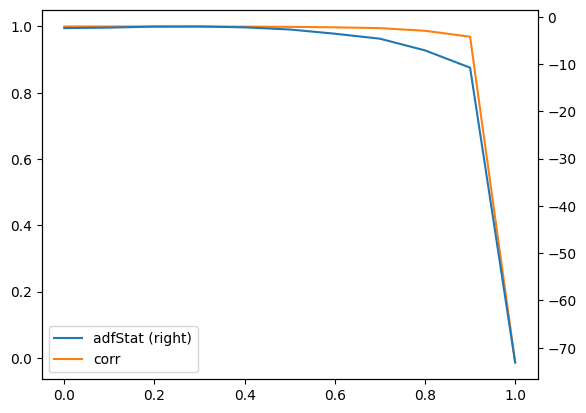

In [14]:
print(optimal_d) #this value is the order of differncing needed to achieve stationarity while preserving as much memory as possible
results[['adfStat', 'corr']].plot(secondary_y='adfStat') #here is beautiful plot that shows the relationship between adt statistics value and corr with original series

##Second step: Calculate the weights
   - The weights are determined by the fractional differencing order 'd'
   - They follow a specific pattern based on the binomial expansion of (1-L)^d, where L is the lag operator
   - The weights decrease as you go further back in **time**

In [15]:
#now if i understand correctly we are supposed to find weights

In [16]:
df_size = df.count() # the size param in getWeights() should be the size of the series
getWeights(d = optimal_d,size = df_size) # the d is optimal_d you calculated before

array([[-2.40058468e-07],
       [-2.40096099e-07],
       [-2.40133740e-07],
       ...,
       [-1.24753533e-01],
       [-5.22202134e-01],
       [ 1.00000000e+00]])

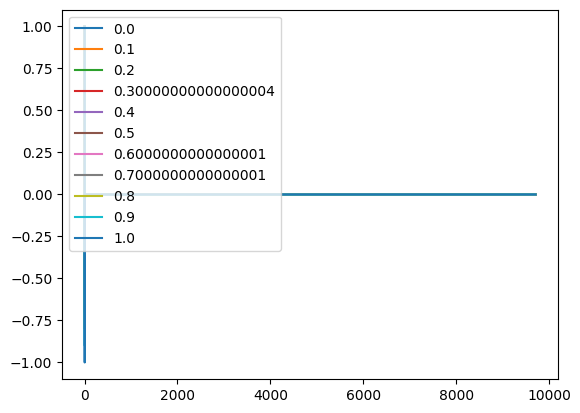

In [17]:
plotWeights(dRange=[0,1], nPlots=11, size=df_size) #dRange is np.linspace(0, 1, 11),but now the first 2 values you provide as tuple and third you give to nPlots, size is the same as above
# plotWeights(dRange=[1,2], nPlots=11, size=df_size) # this one i took from book i dont know why he showed this one, for us the d range is from 0 to 1

## Apply the fractional differencing using simple method
   - Use the calculated weights to create a weighted sum of past observations
   - This step transforms your original series into a fractionally differenced series

In [22]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def fracDiff_FFD(series, d, thres=1e-5):
    """
    Fractionally difference series using fixed-width window.
    :param series: input time series
    :param d: fractional order of differencing
    :param thres: threshold for weight significance
    :return: fractionally differenced series
    """
    start_time = time.time()  # Start timing

    # 1) Compute weights for the fractional differencing
    w = getWeights_FFD(d, thres)
    width = len(w) - 1

    # 2) Apply weights to the values
    df = {}
    for name in tqdm(series.columns, desc="Processing columns", unit="column"):  # Progress bar for columns
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series(dtype='float64')  # Initialize empty series for the result

        # Progress bar for rows
        for iloc1 in tqdm(range(width, seriesF.shape[0]), desc=f"Processing rows in {name}", leave=False):
            loc0, loc1 = seriesF.index[iloc1-width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue  # Skip if the value is NaN or infinite

            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]

        df[name] = df_.copy(deep=True)

    # Print total time taken
    elapsed_time = time.time() - start_time
    print(f"Total time taken: {elapsed_time:.2f} seconds")

    return pd.concat(df, axis=1)


In [23]:
# if df is a Series, we need to convert it to a DataFrame
df = pd.DataFrame(df, columns=['Close'])

# now we can apply the fracDiff function
df_frac_diff = fracDiff_FFD(series=df, d=optimal_d)


Processing columns:   0%|          | 0/1 [00:00<?, ?column/s]<ipython-input-22-de3cad4f49b2>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()

Processing columns: 100%|██████████| 1/1 [00:09<00:00,  9.74s/column]

Total time taken: 9.75 seconds


<Axes: xlabel='Date'>

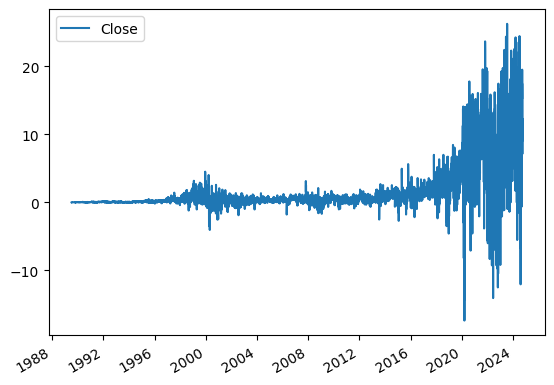

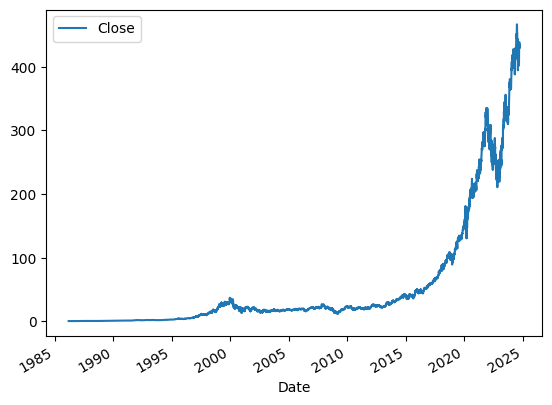

In [28]:
df_frac_diff.plot()
df.plot()

## Apply the fractional differencing using vec method


In [26]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar
import time  # Import time for tracking start and end times

def fracDiff_FFD_vec(series, d, thres=1e-5):
    """
    Fractionally difference series using a fixed-width window method (vectorized).

    :param series: input time series (Pandas DataFrame)
    :param d: fractional order of differencing
    :param thres: threshold for weight significance (to limit small weights)
    :return: fractionally differenced series (Pandas DataFrame)
    """
    # Record the start time
    start_time = time.time()
    start_readable = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
    print(f"Start time: {start_readable}")

    # 1) Compute the weights for the fractional differencing using FFD
    w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}

    # Wrap the loop over series.columns with tqdm for the progress bar
    for name in tqdm(series.columns, desc="Processing columns", unit="column"):
        seriesF = series[[name]].fillna(method='ffill').dropna()

        # Convert the series to a 2D NumPy array for vectorized computation
        values = seriesF.values
        diff_values = np.full(values.shape, np.nan)

        # Perform the fractional differencing for each window in a vectorized way
        for iloc1 in tqdm(range(width, values.shape[0]), desc=f"Processing rows in {name}", leave=False):
            if np.isfinite(values[iloc1, 0]):
                # Use NumPy's dot product to apply the weights in a vectorized manner
                diff_values[iloc1] = np.dot(w.T, values[iloc1-width:iloc1+1])[0]

        # Convert the resulting array back to a Pandas Series and assign it to the dictionary
        df[name] = pd.Series(diff_values[:, 0], index=seriesF.index)

    # Record the end time
    end_time = time.time()
    end_readable = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
    elapsed_time = end_time - start_time

    # Print end time and total duration
    print(f"End time: {end_readable}")
    print(f"Total time taken: {elapsed_time:.2f} seconds")

    return pd.DataFrame(df)

In [27]:
# if df is a Series, we need to convert it to a DataFrame
df = pd.DataFrame(df, columns=['Close'])

# now we can apply the fracDiff function
df_frac_diff_vec = fracDiff_FFD_vec(series=df, d=optimal_d)
df_frac_diff_vec =  df_frac_diff_vec.dropna()

Start time: 2024-09-26 16:49:59


Processing columns:   0%|          | 0/1 [00:00<?, ?column/s]<ipython-input-26-ea3f650ecd1e>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()

Processing columns: 100%|██████████| 1/1 [00:00<00:00, 13.09column/s]

End time: 2024-09-26 16:49:59
Total time taken: 0.09 seconds


<Axes: xlabel='Date'>

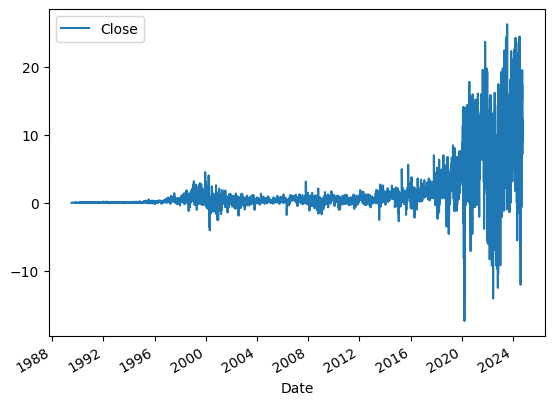

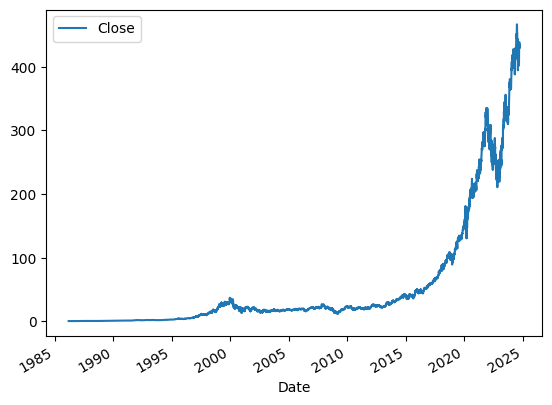

In [29]:
df_frac_diff_vec.plot()
df.plot()

###comparing whether the df's are equal

In [41]:
if df_frac_diff_vec.equals(df_frac_diff):
    print("The DataFrames are identical.")
else:
    print("The DataFrames are not identical.")


The DataFrames are identical.


In [42]:
import pandas as pd

try:
    pd.testing.assert_frame_equal(df_frac_diff_vec, df_frac_diff)
    print("The DataFrames are identical.")
except AssertionError as e:
    print("The DataFrames are not identical.")
    print(e)


The DataFrames are not identical.
DataFrame.index are different

Attribute "names" are different
[left]:  ['Date']
[right]: [None]


In [43]:
tolerance = 1e-6  # Define an acceptable tolerance for floating-point differences

# Check if the difference is within the tolerance level
if np.allclose(df_frac_diff_vec.values, df_frac_diff.values, atol=tolerance):
    print("The DataFrames are approximately equal within the tolerance.")
else:
    print("The DataFrames are not equal.")


The DataFrames are approximately equal within the tolerance.


In [44]:
# Check element-wise comparison within a tolerance
comparison = np.isclose(df_frac_diff_vec.values, df_frac_diff.values, atol=tolerance)
if comparison.all():
    print("The DataFrames are approximately equal within the tolerance.")
else:
    print("The DataFrames are not equal.")

    # Find the index of differences
    diff_indices = np.where(~comparison)
    print(f"Differences found at indices: {diff_indices}")


The DataFrames are approximately equal within the tolerance.


In [45]:
print("Summary statistics of vectorized version:")
print(df_frac_diff_vec.describe())

print("\nSummary statistics of original version:")
print(df_frac_diff.describe())


Summary statistics of vectorized version:
             Close
count  8875.000000
mean      1.599841
std       3.524613
min     -17.378292
25%       0.057511
50%       0.411388
75%       1.264747
max      26.237203

Summary statistics of original version:
             Close
count  8875.000000
mean      1.599841
std       3.524613
min     -17.378292
25%       0.057511
50%       0.411388
75%       1.264747
max      26.237203


In [46]:
# Check for NaNs in both DataFrames
nan_count_vec = df_frac_diff_vec.isna().sum()
nan_count_orig = df_frac_diff.isna().sum()

print(f"NaN counts in vectorized version: \n{nan_count_vec}")
print(f"NaN counts in original version: \n{nan_count_orig}")


NaN counts in vectorized version: 
Close    0
dtype: int64
NaN counts in original version: 
Close    0
dtype: int64


##Fifth step: Verify stationarity


   - Check if the resulting series is stationary using tests like ADF or KPSS
   - If not stationary, you may need to adjust the 'd' value and repeat steps 3-5

In [47]:
adfuller(df['Close'], maxlag=1, regression='c', autolag=None)

(3.8306867284320267,
 1.0,
 1,
 9711,
 {'1%': -3.431023569086351,
  '5%': -2.861837676493152,
  '10%': -2.5669284480753376})

In [48]:
adfuller(df_frac_diff['Close'], maxlag=1, regression='c', autolag=None)

(-20.501432150292608,
 0.0,
 1,
 8873,
 {'1%': -3.4310872019402154,
  '5%': -2.8618657948480255,
  '10%': -2.566943415595445})

In [49]:
adfuller(df_frac_diff_vec['Close'], maxlag=1, regression='c', autolag=None)

(-20.501432150292608,
 0.0,
 1,
 8873,
 {'1%': -3.4310872019402154,
  '5%': -2.8618657948480255,
  '10%': -2.566943415595445})